# objective :
1) to load the data with 1000 positive reviews and negative reviews each
2) to convert the data into vectors
3) to plot tsne for each of bag of words , if-idf , word2vec , avg word2vec , if-idf weighted word2vec

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

In [ ]:
con = sqlite3.connect(r'c:\users\sravani\downloads\database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score !=3 """, con) 


Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating

In [ ]:
def partition(x):
    if x < 3:
        return 0
    return 1

changing reviews with score less than 3 to be positive and vice-versa

In [ ]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)


Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


sorting data according productID in ascending order

In [ ]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

 deduplication of entries

In [ ]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep = 'first', inplace = False)
final.shape


(364173, 10)

checking to see how much percentage of data still remains

In [ ]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

removing the rows whose helpfulness numerator is greater than helpfulness denominator

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator ]


In [ ]:
final.shape

(364171, 10)

In [ ]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

find sentences containing html tags

In [ ]:
import re
i= 0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [ ]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence):
    cleanr = recompile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/)]',r'',cleaned)
    return cleaned
print(stop)
print('********************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sravani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"haven't", 'y', "wouldn't", 'before', 'aren', 'hasn', 'mustn', 'o', "mightn't", 'why', 'you', 'isn', 'wasn', 'ourselves', 'it', 'or', "don't", 'those', 'whom', 'more', 'with', 'so', 'into', "doesn't", 'which', 'if', "you'll", 'they', 'these', 'until', 've', 'weren', "weren't", 'all', 'from', 'won', 'only', 'of', "she's", 'he', 'being', 'll', "won't", 'how', 'that', 'her', 'after', "isn't", 'herself', 'wouldn', 'haven', 'not', 'this', 'down', 'ours', 'in', 'no', 'yours', 'by', 'as', 'below', 'ma', 'doing', 'we', 'there', "hasn't", 'its', 'hers', 'an', 'can', 'was', 'but', 'further', 'ain', 'himself', 'than', 'she', 'having', 'each', 'd', 'itself', 'him', 'out', 'because', 'during', 'through', 'here', 'the', 'just', 'against', 'my', "needn't", 'above', 'nor', 'most', 're', 'mightn', 'themselves', 'shan', 'who', 'to', 'shouldn',

pre processing phase

In [ ]:
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sent in enumerate(tqdm(final['text'].values)):
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if(cleaned_words.lower()not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['score'].values)[i] == 1:
                            all_positive_words.append(s)
                        if (final['score'].values)[i] == 0:
                            all_negative_words.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    final['CleanedText']= final_string
    final['CleanedText']= final_string.str.decode("utf-8")
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor
    conn.text_factory = str
    final.to_sql('Reviews',conn, schema = None, if_exists= 'replace',\
                index= True, index_label= None, chunksize = None, dtype=None)
    conn.close()
    with open('positive_words.pkl','wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negative_words.pkl','wb') as f:
        pickle.dump(all_negative_words, f)


In [ ]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",conn)
    conn.close()
else :
    print("please the above cell")    

In [ ]:
print(final.shape)

(364171, 12)


In [ ]:
final.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [ ]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [ ]:
data_pos = final[final["Score"]=='positive'].sample(n=1000)
data_neg = final[final["Score"]== 'negative'].sample(n=1000)
final_2000 = pd.concat([data_pos,data_neg])

In [ ]:
Score_2000=final_2000['Score']

In [ ]:
Score_2000.shape

(2000,)

bag of words

In [ ]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final_2000['CleanedText'].values)
print("the type of count vectorizer", type(final_counts))
print("the shape of out text BOW vectorizer", final_counts.get_shape())
print("the number of unique words", final_counts.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (2000, 6627)
the number of unique words 6627


In [ ]:
final_counts.get_shape()

(2000, 6627)

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,0))
final_unigram_counts = count_vect.fit_transform(final_2000['CleanedText'].values)
print('the tupe of count vectorizer', type(final_unigram_counts))
print('the shape of out text BOW vectorizer',final_unigram_counts.get_shape())
print('the number of unique words of unigrams',final_unigram_counts.get_shape()[1])

the tupe of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (2000, 6627)
the number of unique words of unigrams 6627


In [ ]:
from sklearn.preprocessing import StandardScaler 
std_data = StandardScaler(with_mean = False).fit_transform(final_unigram_counts)
std_data.shape

(2000, 6627)

In [ ]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [ ]:
std_data = std_data.todense()


In [ ]:
type(std_data)

numpy.matrixlib.defmatrix.matrix

In [ ]:
final_2000['Score'].value_counts()

negative    1000
positive    1000
Name: Score, dtype: int64

tsne for BOW

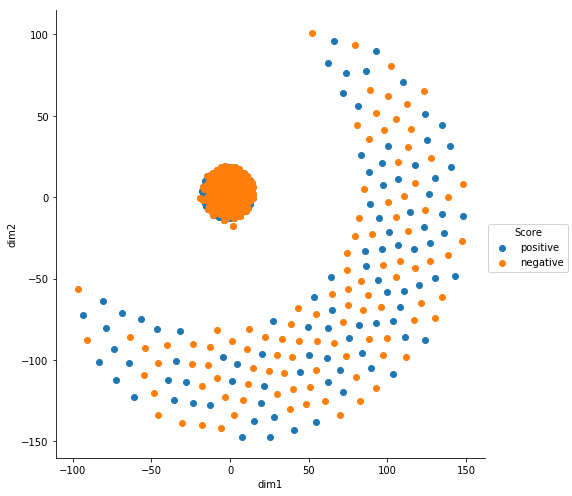

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2 , random_state = 0,perplexity= 25, n_iter= 2000)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, Score_2000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "Score"))
sns.FacetGrid(tsne_df , hue = "Score", size = 7).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

inference : the positive and negative reviews are not well seperated

 tf-idf

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,0))
final_tf_idf = tf_idf_vect.fit_transform(final_2000['CleanedText'].values)
print('the type of count vectorizer',type(final_tf_idf))
print('the type of out text TFIDF vectorizer',final_tf_idf.get_shape())
print('the type of unique words of unigrams',final_tf_idf.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the type of out text TFIDF vectorizer (2000, 6627)
the type of unique words of unigrams 6627


In [ ]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:50])

some sample features(unique words in the corpus) ['abamectin', 'abandon', 'abbott', 'abdomin', 'abil', 'abl', 'abnorm', 'abomin', 'abrupt', 'absent', 'absolut', 'absolutey', 'absorb', 'absurd', 'abund', 'acai', 'acceler', 'accentu', 'accept', 'access', 'accid', 'accident', 'accompani', 'accord', 'account', 'acct', 'accumil', 'accumul', 'accur', 'accustom', 'acer', 'acet', 'acetaminophen', 'ach', 'achiev', 'achill', 'acid', 'acidosi', 'ack', 'acke', 'acknowledg', 'acn', 'acquir', 'acrid', 'across', 'act', 'action', 'activ', 'actual', 'ad']


In [ ]:
final_2000.shape

(2000, 12)

In [ ]:
def top_tfidf_feats(row, features, top_n = 25):
    '''get top n tfidf values in row and return them with their corresponding feature names'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i])for i in topn_ids]
    df= pd.DataFrame(top_feats)
    df.columns = ['feature','tfidf']
    return df
top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)

In [ ]:
top_tfidf

,feature,tfidf
0,begon,0.491463
1,heal,0.466266
2,everyday,0.405311
3,salt,0.273236
4,per,0.264591
5,nice,0.237018
6,know,0.223150
7,look,0.204042
8,dont,0.182396
9,love,0.160813


In [ ]:
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)
std_data = std_data.todense()

In [ ]:
std_data.shape


(2000, 6627)

In [ ]:
type(std_data)

numpy.matrixlib.defmatrix.matrix

tsne for tfidf

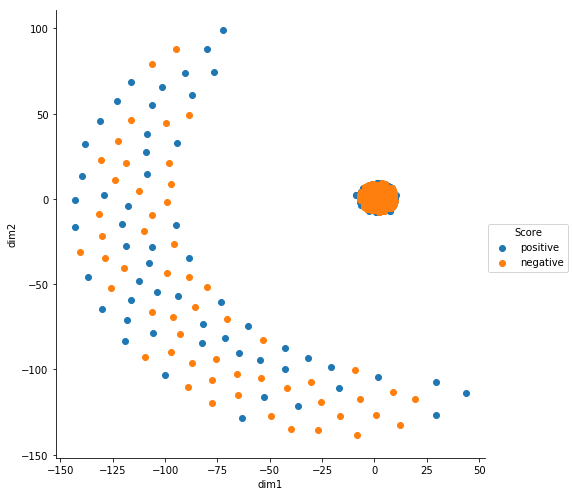

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2,random_state = 0,perplexity = 25, n_iter = 2000)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, Score_2000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1","dim2","Score"))
sns.FacetGrid(tsne_df , hue ="Score", size = 7).map(plt.scatter, 'dim1','dim2').add_legend()
plt.show()

inference : we cannot differentiate between positive and negative reviews

word 2 vec

In [ ]:
i = 0
list_of_sent = []
for sent in final_2000['CleanedText'].values:
    list_of_sent.append(sent.split())

In [ ]:
len(list_of_sent)

2000

In [ ]:
print(final_2000['CleanedText'].values[0])
print('*********')
print(list_of_sent[0])

wow amaz food human write behalf belov snowsho mocha mocha love femal doesnt care eat would rather cuddl eat lol nibbl bite wet fanci feast food tri grill classic varieti pack fanci feast hour later come back eat bite time til none plate put plate well today first day eat gosh almost ate lap food greedili lol think mocha favorit flavor fanci feast flavor far like food smell like real fish can tuna smell actual fish meat even skin healthiest part fish even see tini tini brine shrimp wow realli real stuff check nutrit analysi crude protein least highest fanci feast varieti also like artifici anyth includ flavor unlik fanci feast varieti negat bit broth like kind like grill fanci feast tad less problem item product thailand better product china would never buy cat food matter top notch stuff less min later mocha return finish rest meal
*********
['wow', 'amaz', 'food', 'human', 'write', 'behalf', 'belov', 'snowsho', 'mocha', 'mocha', 'love', 'femal', 'doesnt', 'care', 'eat', 'would', 'rat

In [ ]:
w2v_model= Word2Vec(list_of_sent, min_count= 5, size = 50,workers = 4)

In [ ]:
w2v_words =list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words", w2v_words[0:50])

number of words that occured minimum 5 times 2091
sample words ['wow', 'amaz', 'food', 'human', 'write', 'mocha', 'love', 'doesnt', 'care', 'eat', 'would', 'rather', 'lol', 'nibbl', 'bite', 'wet', 'fanci', 'feast', 'tri', 'grill', 'classic', 'varieti', 'pack', 'hour', 'later', 'come', 'back', 'time', 'none', 'plate', 'put', 'well', 'today', 'first', 'day', 'almost', 'ate', 'think', 'favorit', 'flavor', 'far', 'like', 'smell', 'real', 'fish', 'can', 'tuna', 'actual', 'meat', 'even']


In [ ]:
w2v_model.wv.most_similar('tasti')

[('contain', 0.9998254179954529),
 ('top', 0.9998224377632141),
 ('almost', 0.9998189210891724),
 ('wasnt', 0.9998180866241455),
 ('fat', 0.9998177289962769),
 ('mouth', 0.9998161792755127),
 ('stick', 0.999815046787262),
 ('made', 0.999814510345459),
 ('chees', 0.9998141527175903),
 ('actual', 0.9998095035552979)]

In [ ]:
w2v_model.wv.most_similar('like')

[('sweet', 0.9995846748352051),
 ('flavor', 0.999544620513916),
 ('bitter', 0.999536395072937),
 ('better', 0.9995303153991699),
 ('hot', 0.9995094537734985),
 ('smell', 0.9995088577270508),
 ('drink', 0.999498188495636),
 ('tast', 0.9994841814041138),
 ('textur', 0.999461829662323),
 ('smooth', 0.9994549751281738)]

tsne for w2v

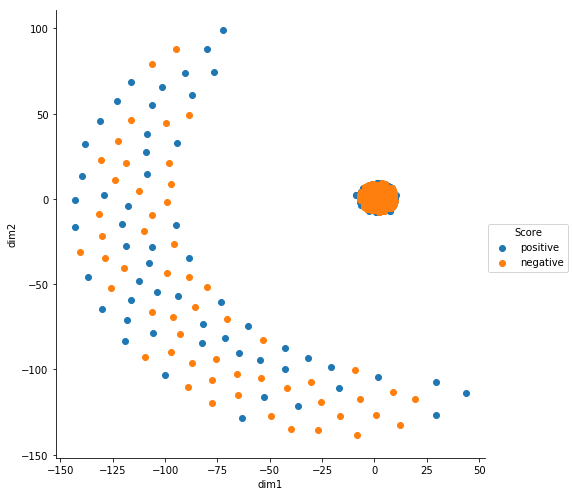

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2,random_state = 0,perplexity = 25, n_iter = 2000)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, Score_2000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1","dim2","Score"))
sns.FacetGrid(tsne_df , hue ="Score", size = 7).map(plt.scatter, 'dim1','dim2').add_legend()
plt.show()

inference:
we cannot draw a line between positive and negative reviews with this plot

#avg w2v

In [ ]:
sent_vectors = [];
for sent in tqdm (list_of_sent): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        try :
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except :
              pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6618.46it/s]


2000
50


In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_2000['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))

tsne for avg w2v

<function matplotlib.pyplot.show>

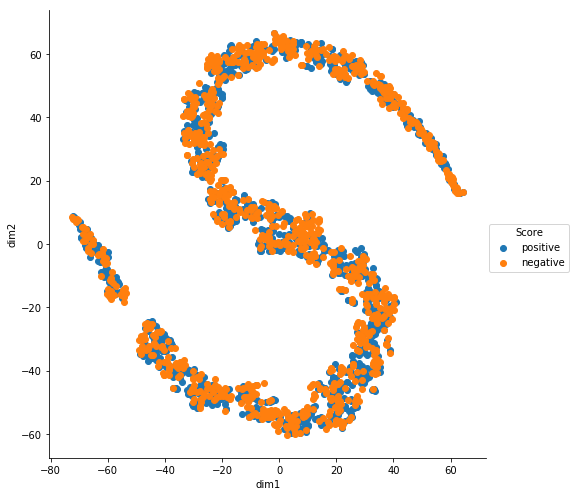

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 25, n_iter = 2000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, Score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))
sns.FacetGrid(tsne_df, hue="Score", size=7).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show

inference : the positive and negative reviews cannot be differentiated by using avg word2vec tsne plot

 TF-IDF weighted Word2Vec

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = [];
row = 0;
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec*tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.16it/s]


tsne for tfidf weighted w2v

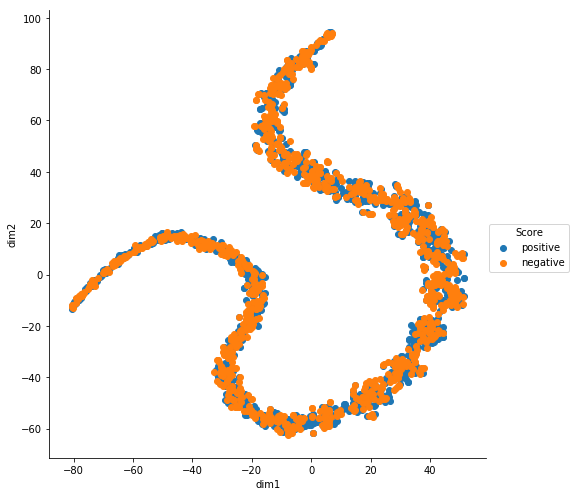

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 25, n_iter = 2000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, Score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))
sns.FacetGrid(tsne_df, hue="Score", size=7).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()

inference:
the positive and negative feedbacks are not well seperated

conclusion :


1) the tsne plots for bag of words , tf-idf , average word2vec , and tf-idf weighted wor2vec are all clumsy
2) one cannot differentiate betweeen positive and negative feedback looking into these tsne plots
3) we have to evolve with other techniques to differentiate 